<a href="https://colab.research.google.com/github/HowardHNguyen/Python/blob/main/Multivariate_Time_Series_Forecasting_with_Seasonality_and_Holiday_Effect_Using_Prophet_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources

- [Blog post](https://medium.com/grabngoinfo/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57) for this notebook
- Video tutorial for this post on [YouTube](https://www.youtube.com/watch?v=1YAEk3v9S-o&list=PLVppujud2yJpVhqR0tqdw1lQPUuplBYM6&index=2)
- More video tutorials on [time series](https://www.youtube.com/playlist?list=PLVppujud2yJpVhqR0tqdw1lQPUuplBYM6)
- More blog posts on [time series](https://medium.com/@AmyGrabNGoInfo/list/time-series-0aba8a92cca1)


For more information about data science and machine learning, please check out my [YouTube channel](https://www.youtube.com/channel/UCmbA7XB6Wb7bLwJw9ARPcYg), [Medium Page](https://medium.com/@AmyGrabNGoInfo) and [GrabNGoInfo.com](https://grabngoinfo.com/tutorials/), or follow GrabNGoInfo on [LinkedIn](https://www.linkedin.com/company/grabngoinfo/).

# Intro

Do you want to build a time series model that incorporates seasonalities, holidays, special events, and other features? In this tutorial, we will talk about how to achieve this using Facebook Prophet in Python. After the tutorial, you will learn:
* How to include seasonalities in time series prediction?
* How to add standard holidays of a country?
* How to add special events such as Super Bowl?
* How to add additional predictors?
* How the time series model performance is impacted by seasonalities, holidays, special events, and additional features?

Let's get started!

# Step 1: Install and Import Libraries

In the first step, we will install and import libraries.

`yfinance` is the python package for pulling stock data from Yahoo Finance. `prophet` is the package for the time series model. After installing `yfinance` and `prophet`, we will import them into the notebook.

We will also import `pandas` and `numpy` for data processing, `seaborn` and `matplotlib` for visualization, and `mean_absolute_error` and `mean_absolute_percentage_error` for the model performance evaluation.

In [1]:
# Install libraries
!pip install yfinance prophet

In [70]:
# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Step 2: Pull Data

The second step pulls stock data from Yahoo Finance API. We will pull 2 years of daily data from the beginning of 2020 to the end of 2021.

* `start_date = '2020-01-02'` because January 1st is a holiday, and there is no stock data on holidays and weekends.
* `end_date = '2022-01-01'` because `yfinance` excludes the end date, so we need to add one day to the last day of the data end date.
* `train_end_date = '2021-12-15'` means that the splitting date for the training and testing dataset is December 15th of 2021.


In [71]:
# Data start date
start_date = '2020-01-02'

# Data end date. yfinance excludes the end date, so we need to add one day to the last day of data
end_date = '2023-10-27'

# Date for splitting training and testing dataset
train_end_date = '2023-05-01'

We will download the closing prices for two tickers, `GOOG` and `UNH`. `GOOG` is the ticker for Google, and `UNH` is the ticker for the Vanguard Total Stock Market Index Fund ETF.

The goal of the time series model is to predict the closing price of Google stock. The closing price of UNH will be used as an additional predictor.

In [72]:
# Pull close data from Yahoo Finance for the list of tickers
ticker_list = ['GOOG', 'UNH']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Take a look at the data
data.head()

[*********************100%%**********************]  2 of 2 completed


Close            
                 GOOG         UNH
Date                             
2020-01-02  68.368500  292.500000
2020-01-03  68.032997  289.540009
2020-01-06  69.710503  291.549988
2020-01-07  69.667000  289.790009
2020-01-08  70.216003  295.899994

The downloaded dataset is in the pandas dataframe format. We can see that the output has two-level column names. Using `droplevel`, the first level column name `Close` is dropped.

In [73]:
# Drop one level of the column names
data.columns = data.columns.droplevel(0)

# Take a look at the data
data.head()

,GOOG,UNH
Date,,
2020-01-02,68.368500,292.500000
2020-01-03,68.032997,289.540009
2020-01-06,69.710503,291.549988
2020-01-07,69.667000,289.790009
2020-01-08,70.216003,295.899994


In [74]:
data.tail()

,GOOG,UNH
Date,,
2023-10-20,136.740005,527.030029
2023-10-23,137.899994,521.570007
2023-10-24,140.119995,525.000000
2023-10-25,126.669998,530.210022
2023-10-26,123.440002,528.359985


Using `.info`, we can see that the dataset has 505 records and there are no missing values.

In [75]:
# Information on the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 962 entries, 2020-01-02 to 2023-10-26
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOOG    962 non-null    float64
 1   UNH     962 non-null    float64
dtypes: float64(2)
memory usage: 22.5 KB


Next, let's visualize the closing prices of the two tickers using `seaborn`, and add the legend to the plot using `matplotlib`. We can see that the price for Google increased a lot starting in late 2020, and almost doubled in late 2021.

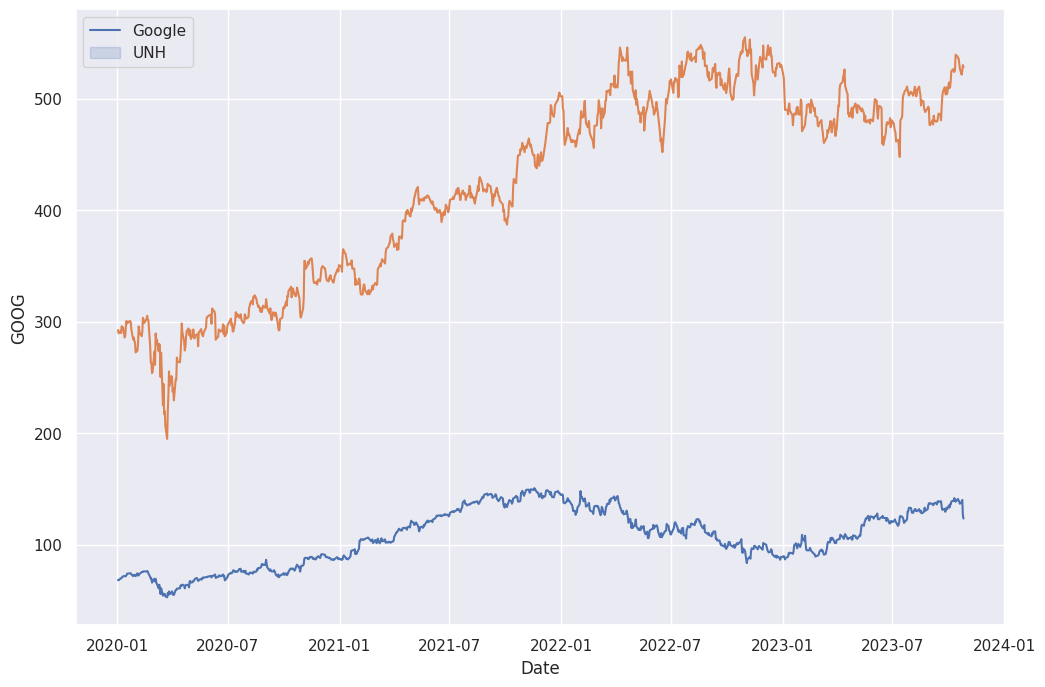

In [76]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['GOOG'])
sns.lineplot(x=data.index, y=data['UNH'])
plt.legend(['Google', 'UNH'])

# Step 3: Data Processing

Step 3 transforms the dataset into a time series modeling dataset.


Prophet requires at least two columns as inputs: a `ds` column and a `y` column.
* The `ds` column has the time information. Currently we have the date as the index, so we reset the index and rename `date` to `ds`.
* The y column has the time series values. In this example, because we are predicting the Google closing price, the column name `GOOG` is changed to `y`.
* There is no pre-defined name for the additional predictor in prophet, so we can keep the name `UNH` as is.

In [77]:
# Change variable names
data = data.reset_index()
data.columns = ['ds', 'y', 'UNH']

# Take a look at the data
data.head()

,ds,y,UNH
0,2020-01-02,68.368500,292.500000
1,2020-01-03,68.032997,289.540009
2,2020-01-06,69.710503,291.549988
3,2020-01-07,69.667000,289.790009
4,2020-01-08,70.216003,295.899994


Next, let's check the correlation between the Google stock closing price and the UNH closing price.

In [78]:
# Check correlation
data.corrwith(data["y"])

<ipython-input-78-727934c321f9>:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corrwith(data["y"])


y      1.000000
UNH    0.660812
dtype: float64

The value of 0.660 is pretty good number, indicating that there is a high correlation between the two closing prices. Therefore, UNH closing price is a potential good predictor for the Google closing price.

# Step 4: Train Test Split

In step 4, we will do the train test split. For time series data, usually a threshold date is chosen, then we set the dates before the threshold to be the training dataset and the dates after the threshold to be the testing dataset.

Based on the threshold date (`train_end_date`) we set before, there are 494 data points in the training dataset and 11 data points in the testing dataset.

In [79]:
# Train test split
train = data[data['ds'] <= train_end_date]
test = data[data['ds'] > train_end_date]

# Check the shape of the dataset
print(train.shape)
print(test.shape)

(838, 3)
(124, 3)


Checking the minimum and maximum values for the train and test dataset separately gave us the starting and ending dates.

The training dataset has the dates from January 2nd, 2020 to May 1st, 2023, and the testing dataset has the dates from May 2nd, 2023 to Oct 26th, 2023.

In [80]:
# Check the start and end time of the training and testing dataset
print('The start time of the training dataset is ', train['ds'].min())
print('The end time of the training dataset is ', train['ds'].max())
print('The start time of the testing dataset is ', test['ds'].min())
print('The end time of the testing dataset is ', test['ds'].max())

The start time of the training dataset is  2020-01-02 00:00:00
The end time of the training dataset is  2023-05-01 00:00:00
The start time of the testing dataset is  2023-05-02 00:00:00
The end time of the testing dataset is  2023-10-26 00:00:00


# Step 5: Baseline Model

In step 5, we will build a univariate baseline model using the default prophet hyperparameters, and fit the model using the training dataset.

## Step 5.1: Build Baseline Model

In [81]:
# Use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/p273aj69.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/70ewxqc3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37261', 'data', 'file=/tmp/tmpihc9cek9/p273aj69.json', 'init=/tmp/tmpihc9cek9/70ewxqc3.json', 'output', 'file=/tmp/tmpihc9cek9/prophet_modelzbof5vvc/prophet_model-20231027012444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:24:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:24:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet automatically fits daily, weekly, and yearly seasonalities if the time series is more than two cycles long.

The model information shows that the yearly seasonality and the daily seasonality are disabled.
* The daily seasonality is disabled because we do not have sub-daily time series.
* The yearly seasonality is disabled although we have two years of data because there are no stock price data on holidays and weekends, so we have less than 365 data points for each year.

We will continue with the default values for the baseline model and force the yearly seasonality in the next model to see the impact of the yearly seasonality.

## Step 5.2: Baseline Model Forecast

To make a forecast, we first need to create a future dataframe. `periods=16` means that we would like to make predictions for the next 16 days.

If you remember that the testing dataset has 11 data points, you might wonder why we put 16 instead of 11 as the number of periods here. That is because there are 5 weekends and holidays from December 16th to December 31st in 2021. We need to add those days back in order to get the predictions till December 31st of 2021.

After making the prediction on the future dataframe, we can plot the result using `.plot`.
* The black dots are the actual values.
* The blue line is the prediction.
* The blue shades are the uncertainty interval. The default value for the uncertainty interval is 80%, so we are using 80% here. The uncertainty interval is calculated based on the assumption that the average frequency and magnitude of trend changes in the future will be the same as the historical data. The historical data trend changes are projected forward to get the uncertainty intervals [1].

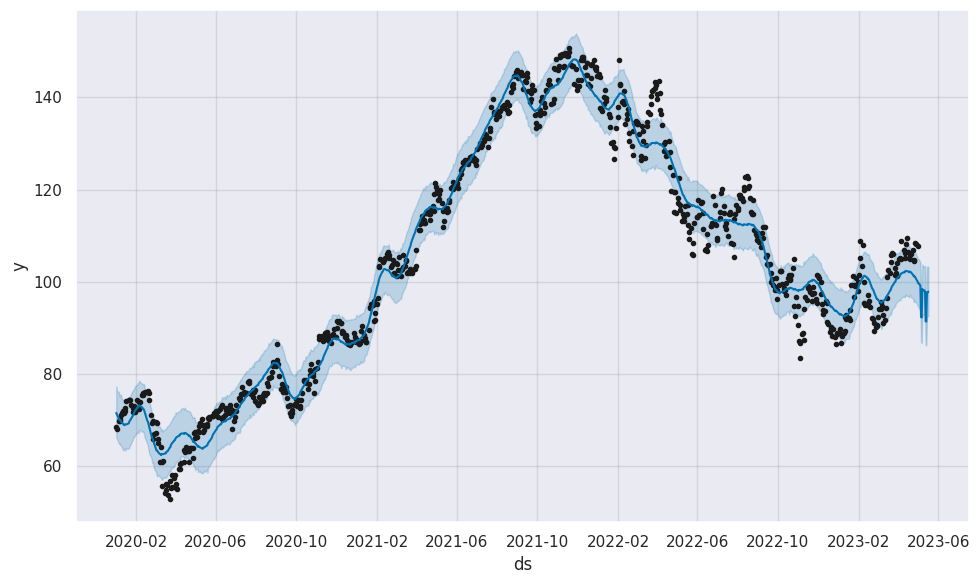

In [82]:
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=16)

# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)

# Visualize the forecast
model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart

In addition to the forecast plot, prophet also provides the components plot.

From the component plot chart, we can see that the Google stock closing price has an overall upward trend. The weekly seasonality shows that the price tends to be lower at the beginning of the week and higher at the end of the week.

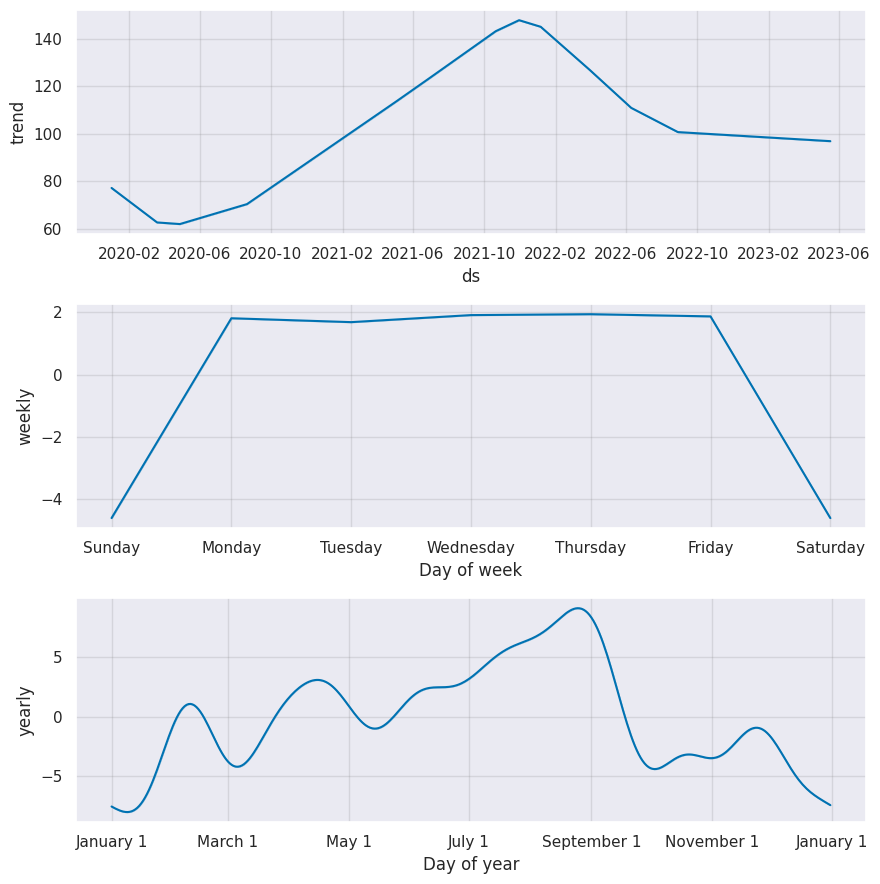

In [83]:
# Visualize the forecast components
model_baseline.plot_components(forecast_baseline);

## Step 5.3: Baseline Model Performance

Next, let's check the model performance.

The forecast dataframe does not include the actual values, so we need to merge the forecast dataframe with the test dataframe to compare the actual values with the predicted values.

The mean absolute error (MAE) for the baseline model is $13, meaning that on average, the forecast is off by \$13. Given the Google price of nearly \$3000, the prediction is not bad.

The mean absolute percent error (MAPE) for the baseline model is 11%, meaning that on average, the forecast is off by 11% of the stock price.

In [84]:
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')


The MAE for the baseline model is 13.650267507635034
The MAPE for the baseline model is 0.11904748799078453


# Step 6: Add Seasonality to Baseline Model

The baseline model already gives us good estimations. Can we tune the model to make the estimations better? In step 6, we will force the model to consider the yearly seasonality.

## Step 6.1 Build Model with Seasonality

When initiating the prophet model, the `yearly_seasonality` and `weekly_seasonality` are explicitly set to True, and then fit on the training data.

In [85]:
# Add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Fit the model on the training dataset
model_season.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/pygxm9t2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/pcw0zoge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13131', 'data', 'file=/tmp/tmpihc9cek9/pygxm9t2.json', 'init=/tmp/tmpihc9cek9/pcw0zoge.json', 'output', 'file=/tmp/tmpihc9cek9/prophet_modelqy3bur4h/prophet_model-20231027012520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:25:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:25:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Step 6.2: Seasonality Model Forecast

The forecast plot is much better than the baseline model. The predictions are more aligned with the actual values, and the uncertainty interval is much narrower.

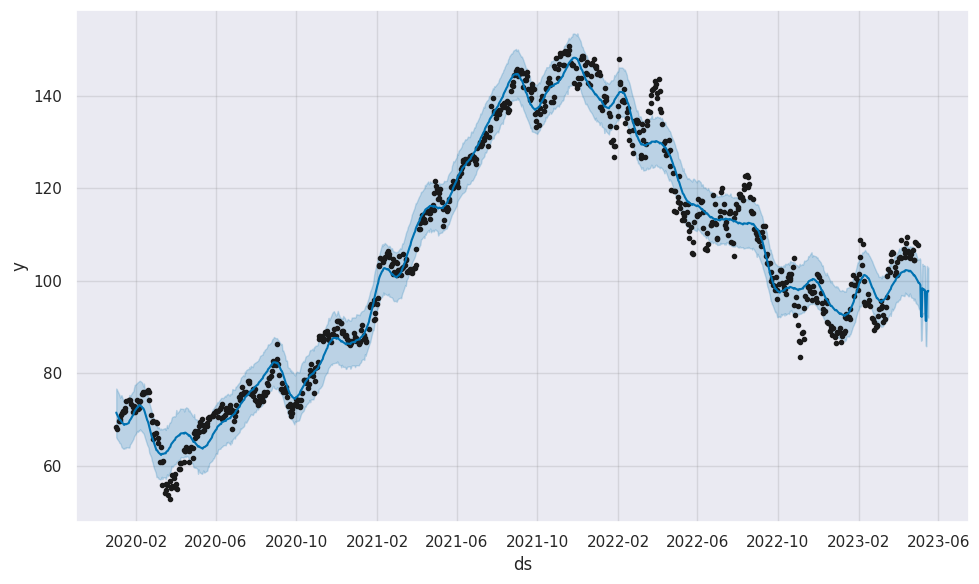

In [86]:
# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=16)

# Make prediction
forecast_season = model_season.predict(future_season)

# Visualize the forecast
model_season.plot(forecast_season); # Add semi-colon to remove the duplicated chart

For the components plot, besides trend and weekly seasonality, there is a yearly seasonality chart, showing the seasonality over the year.

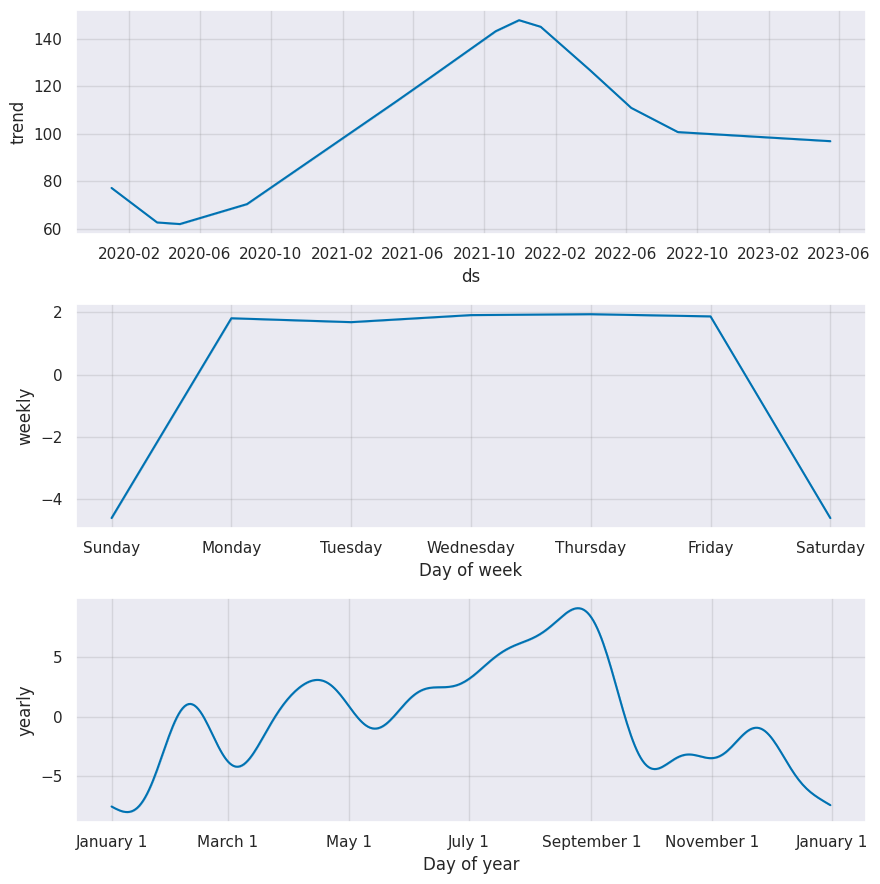

In [87]:
# Visualize the forecast components
model_season.plot_components(forecast_season);

## Step 6.3: Seasonality Model Performance

The model performance is better than the baseline model.
* MAE decreased to \$60 from the baseline model's \$84.
* MAPE decreased to 2% from the baseline model's 2.9%.

In [88]:
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MAPE value
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 13.650267507635034
The MAPE for the seasonality model is 0.11904748799078453


# Step 7: Multivariate Model

In step 7, we added the UNH price as an additional predictor using the `add_regressor` function. `standardize=False` means the regressor will not be standardized.

UNH is chosen as a convenient example of illustrating the process of building a multivariate model. In practice, multiple features need to be created and evaluated as feature engineering and feature selection steps for the model.

## Step 7.1: Build the Multivariate Model

In [89]:
# Add seasonality
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add regressor
model_multivariate.add_regressor('UNH', standardize=False)

# Fit the model on the training dataset
model_multivariate.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/mxssbca0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/j2vsm1wg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18937', 'data', 'file=/tmp/tmpihc9cek9/mxssbca0.json', 'init=/tmp/tmpihc9cek9/j2vsm1wg.json', 'output', 'file=/tmp/tmpihc9cek9/prophet_modelpboajphd/prophet_model-20231027012542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:25:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:25:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Step 7.2: Multivariate Model Forecast

When making forecasts for the multivariate model, we need to make sure that the regressors have values for the forecast periods, so we used left join and appended UNH data to the future dataframe.

In the case that the forecast is for the future without the regressor data, separate models need to be built for the regressors to get the predictions for the future dates.

If there are missing values, we can use `.fillna(method='ffill')` to fill the missing value with the previous day's data.

In [90]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=16)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, data[['ds', 'UNH']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,UNH
840,2023-05-04,487.279999
841,2023-05-05,494.279999
842,2023-05-08,492.619995
843,2023-05-09,490.380005
844,2023-05-10,490.070007
845,2023-05-11,488.760010
846,2023-05-12,491.230011
847,2023-05-15,486.859985
848,2023-05-16,479.720001
849,2023-05-17,484.809998


Compared with the model with no additional regressor, we can see that the model with a regressor has the predictions more aligned with the actual values.

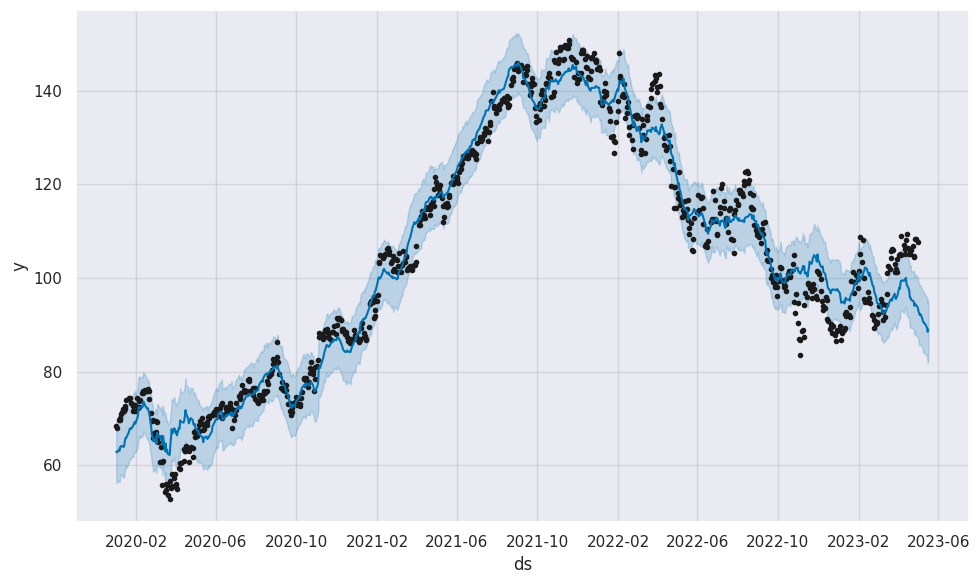

In [91]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

The components plot has one additional chart for the additional regressor.

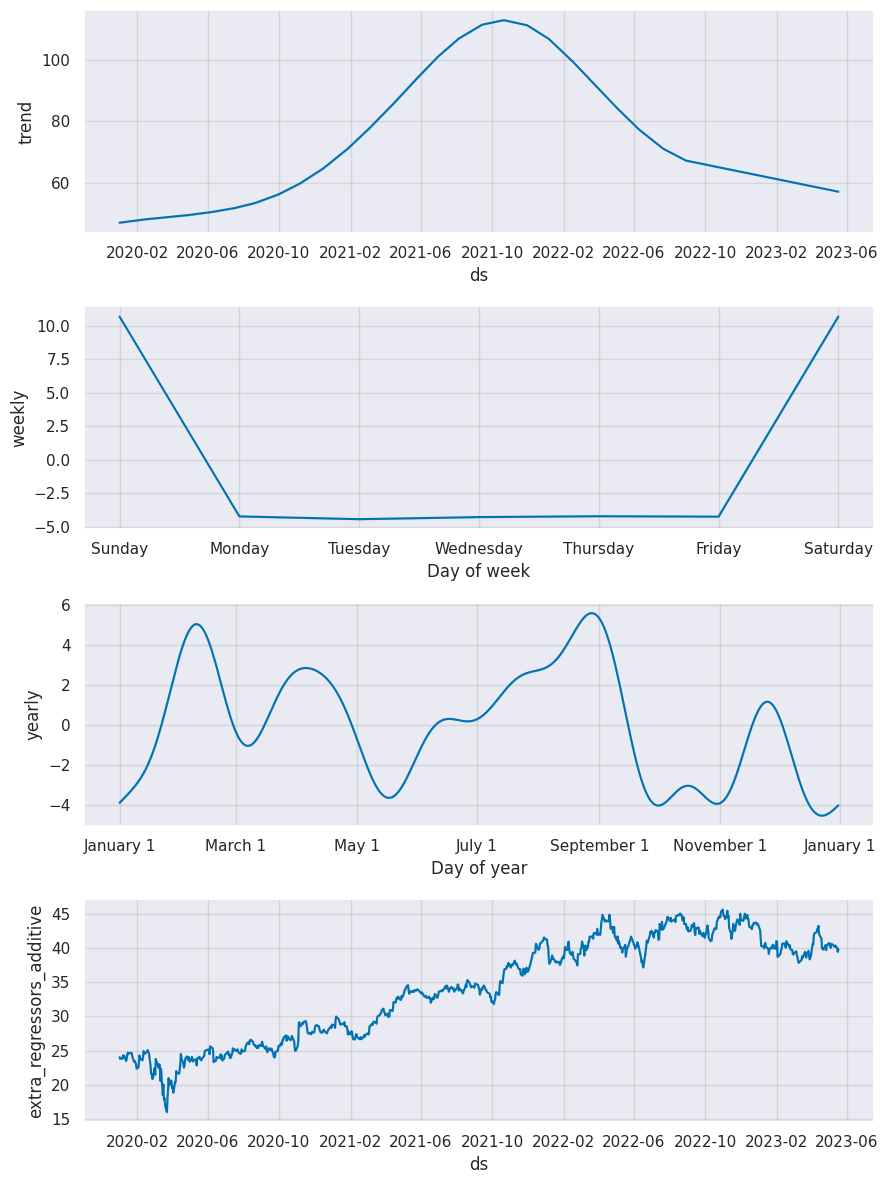

In [92]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

## Step 7.3: Multivariate Model Performance

The multivariate model performance is much better than the univariate model.
* MAE decreased to \$31 from the univariate seasonality model's \$60.
* MAPE decreased to 1% from the univariate seasonality model's 2%.

In [93]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 21.28361029943091
The MAPE for the multivariate model is 0.18701185369167542


# Step 8: Model with Holiday Effect and Event Effect

Besides seasonalities and additional predictors, we can also incorporate holidays and special events in a prophet time series model. In step 8, we will add special events and US holidays to the multivariate model and see how it impacts the model predictions.

## Step 8.1: Build Model with Holiday and Event Effect

Firstly, let's create two special events: COVID start and Super Bowl.

* For the COVID start event, we set the date to be March 15th of 2020, then extend the event to 15 days before and 15 days after using `lower_window` and `upper_window` separately.

* For the Super Bowl event, we set the date in 2020 and 2021 separately, and extend the event to 7 days before and 1 day after.

Then the two events are concatenated together to one dataframe called `events`.

In [94]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2020-02-02,-7,1
1,superbowl,2021-02-07,-7,1


When initiating the prophet model, the dataframe name `events` is passed to the hyperparameter `holidays`.

Prophet has built-in country-specific holidays. We add US holidays to the model using `add_country_holidays` and setting `country_name='US'`.

Using `.train_holiday_names`, we can see the list of holidays and events used for the modeling fitting.

In [95]:
# Add holidays
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=events)

# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')

# Add regressor
model_holiday.add_regressor('UNH', standardize=False)

# Fit the model on the training dataset
model_holiday.fit(train)

# All the holidays and events
model_holiday.train_holiday_names

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/bxiths3b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/3_51twws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74930', 'data', 'file=/tmp/tmpihc9cek9/bxiths3b.json', 'init=/tmp/tmpihc9cek9/3_51twws.json', 'output', 'file=/tmp/tmpihc9cek9/prophet_modelabvdx2b3/prophet_model-20231027012715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:27:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:27:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


0                                               COVID
1                                           superbowl
2                          Martin Luther King Jr. Day
3                               Washington's Birthday
4                                        Columbus Day
5                                      New Year's Day
6                                        Memorial Day
7                                    Independence Day
8                         Independence Day (Observed)
9                                           Labor Day
10                                       Veterans Day
11                                       Thanksgiving
12                                      Christmas Day
13                          New Year's Day (Observed)
14               Juneteenth National Independence Day
15    Juneteenth National Independence Day (Observed)
16                           Christmas Day (Observed)
17                            Veterans Day (Observed)
dtype: object

## Step 8.2: Holiday Model Forecast

When doing a forecast, the holiday and special events effects are included.

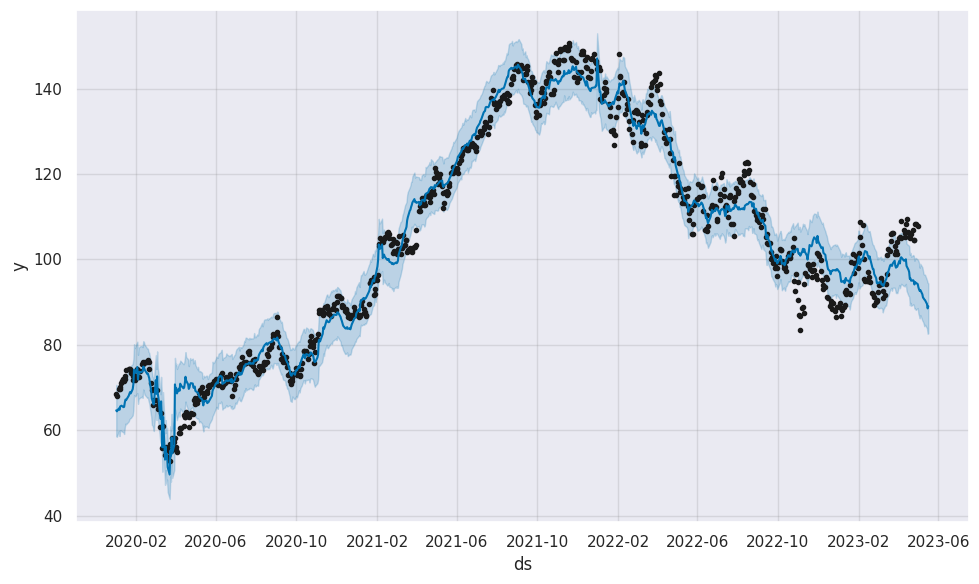

In [96]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=16)

# Append the regressor values
future_holiday = pd.merge(future_holiday, data[['ds', 'UNH']], on='ds', how='inner')

# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')

# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)

# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

The components plot has one additional plot for the holidays including special events.

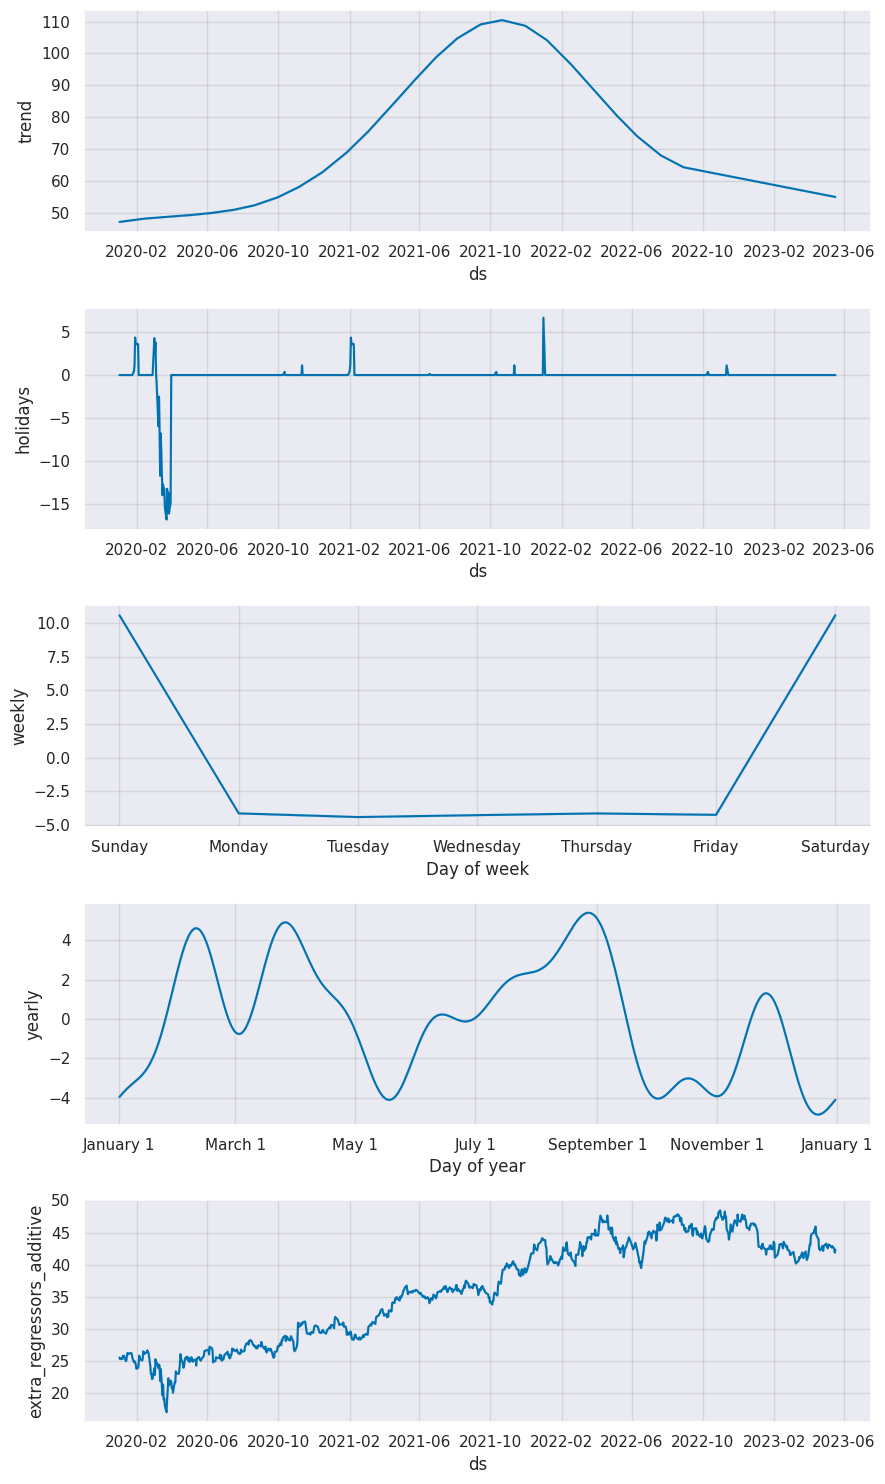

In [97]:
# Visualize the forecast components
model_holiday.plot_components(forecast_holiday);

## Step 8.3: Holiday Model Performance

The added holiday effects did not improve the performance of the multivariate model.

* MAE increased to \$48 from the multivariate model's \$31.
* MAPE increased to 1.6% from the multivariate model's 1%.

This shows that the holidays and two special events added are not good predictors for Google's stock price changes. On the contrary, it introduced noise to the model and decreased the model performance.

However, for some dataset types such as retail sales prediction, having holidays and special events can be very helpful.

In [98]:
# Merge actual and predicted values
performance_holiday = pd.merge(test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')

# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

The MAE for the holiday/event model is 20.969622323129936
The MAPE for the holiday/event model is 0.1841270972329446


# Put All Code Together

[*********************100%%**********************]  2 of 2 completed

<ipython-input-99-23d41d3593c4>:68: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corrwith(data["y"])
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/dnxgl6rz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/a8mobz8o.json



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 962 entries, 2020-01-02 to 2023-10-26
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOOG    962 non-null    float64
 1   UNH     962 non-null    float64
dtypes: float64(2)
memory usage: 22.5 KB
(838, 3)
(124, 3)
The start time of the training dataset is  2020-01-02 00:00:00
The end time of the training dataset is  2023-05-01 00:00:00
The start time of the testing dataset is  2023-05-02 00:00:00
The end time of the testing dataset is  2023-10-26 00:00:00


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25720', 'data', 'file=/tmp/tmpihc9cek9/dnxgl6rz.json', 'init=/tmp/tmpihc9cek9/a8mobz8o.json', 'output', 'file=/tmp/tmpihc9cek9/prophet_modelq0vkeyg_/prophet_model-20231027012843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:28:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:28:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/cvkvfgg2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/b_do5uq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packag

The MAE for the baseline model is 13.650267507635034
The MAPE for the baseline model is 0.11904748799078453


01:28:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/xi6qab8l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/kl14bthf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15026', 'data', 'file=/tmp/tmpihc9cek9/xi6qab8l.json', 'init=/tmp/tmpihc9cek9/kl14bthf.json', 'output', 'file=/tmp/tmpihc9cek9/prophet_modelz06pffrk/prophet_model-20231027012845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:28:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


The MAE for the seasonality model is 13.650267507635034
The MAPE for the seasonality model is 0.11904748799078453


01:28:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/6rzqssr_.json


The MAE for the multivariate model is 21.28361029943091
The MAPE for the multivariate model is 0.18701185369167542


DEBUG:cmdstanpy:input tempfile: /tmp/tmpihc9cek9/701m0vth.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1789', 'data', 'file=/tmp/tmpihc9cek9/6rzqssr_.json', 'init=/tmp/tmpihc9cek9/701m0vth.json', 'output', 'file=/tmp/tmpihc9cek9/prophet_model4dot4kor/prophet_model-20231027012847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:28:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:28:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


The MAE for the holiday/event model is 20.969622323129936
The MAPE for the holiday/event model is 0.1841270972329446


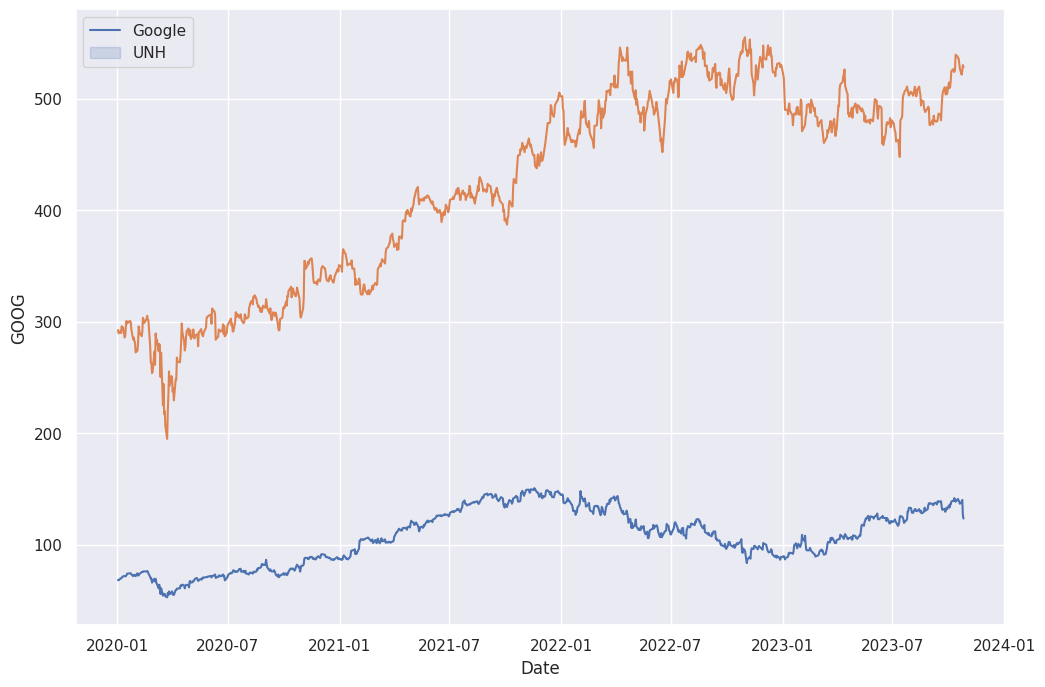

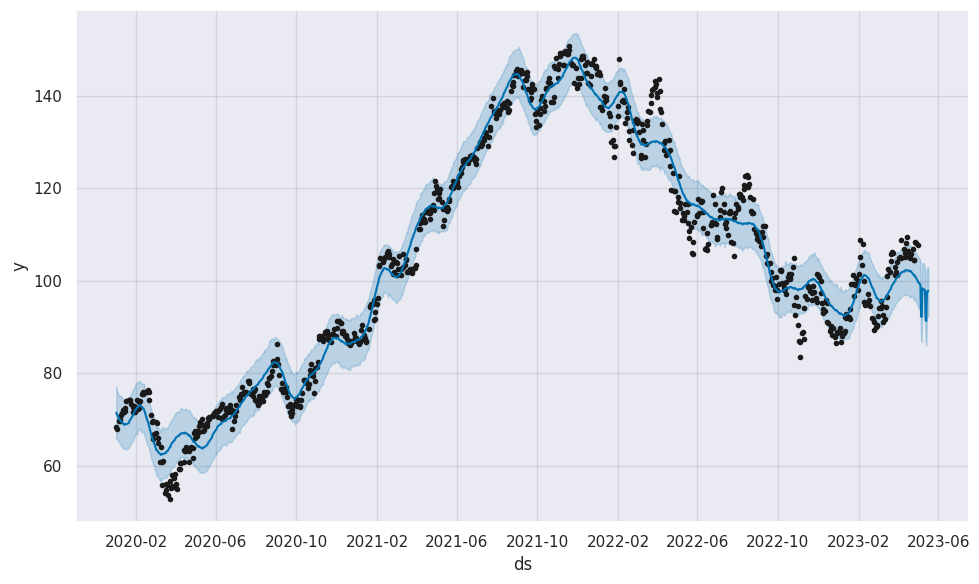

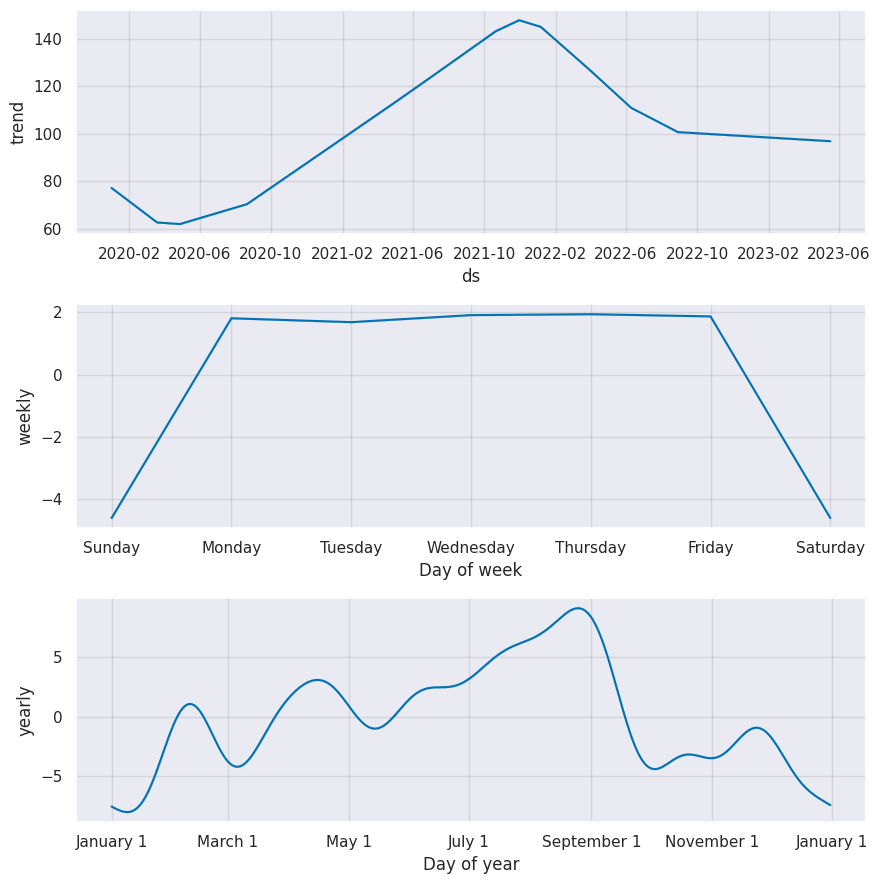

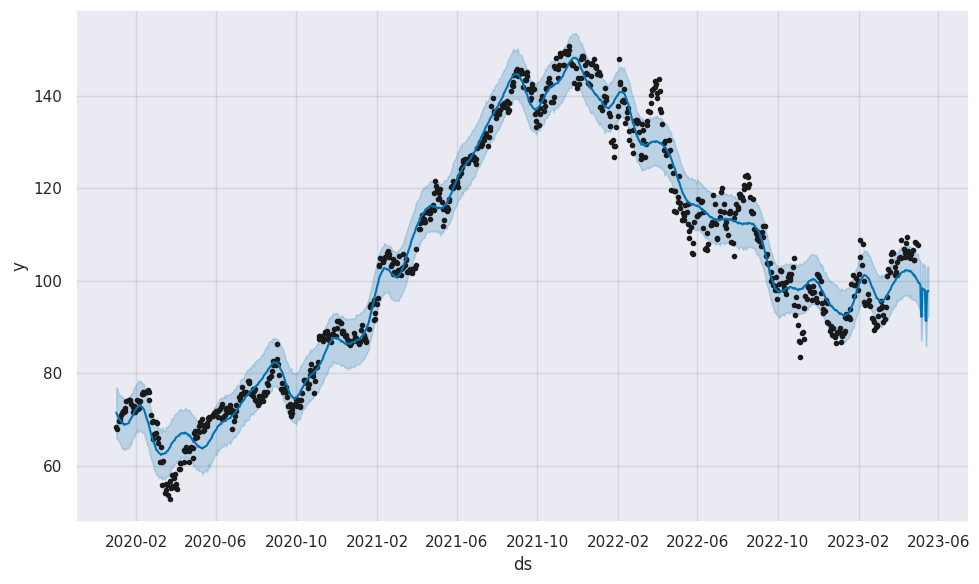

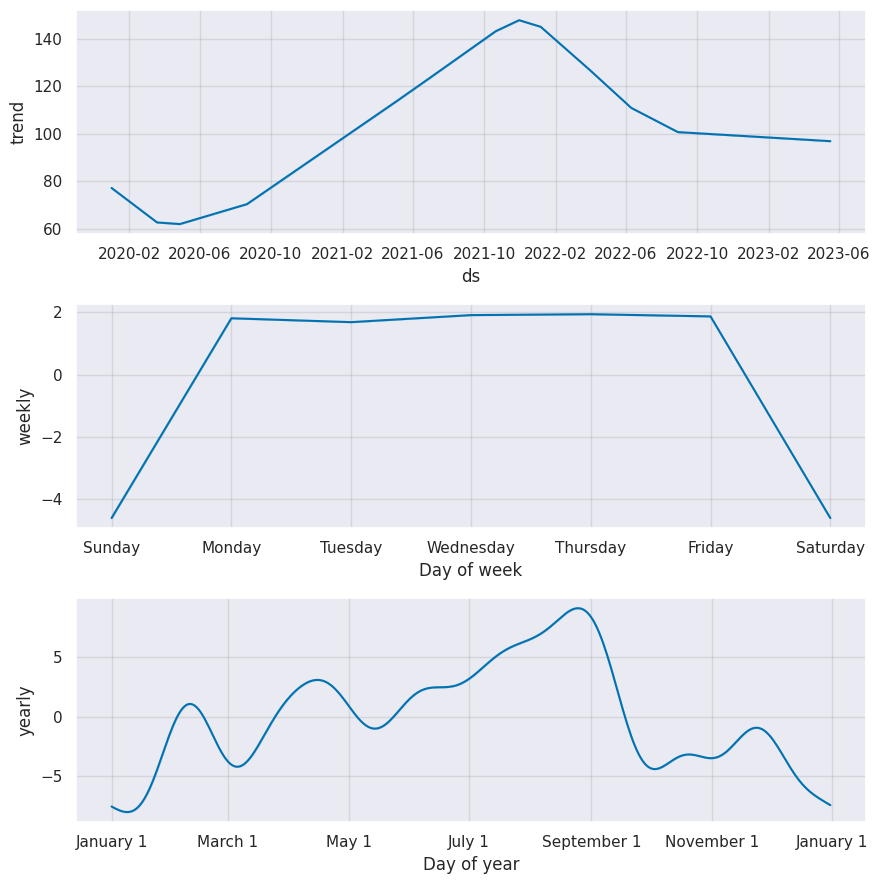

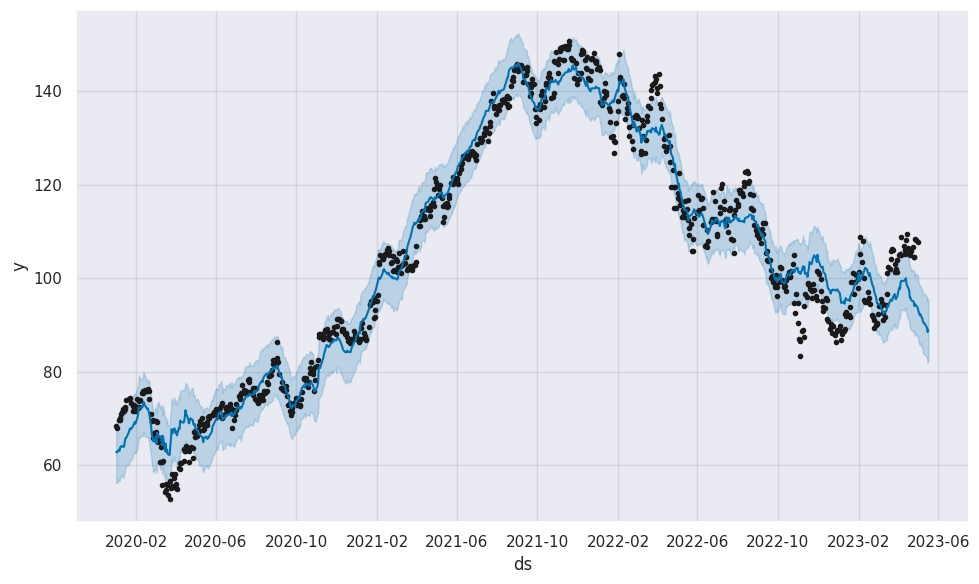

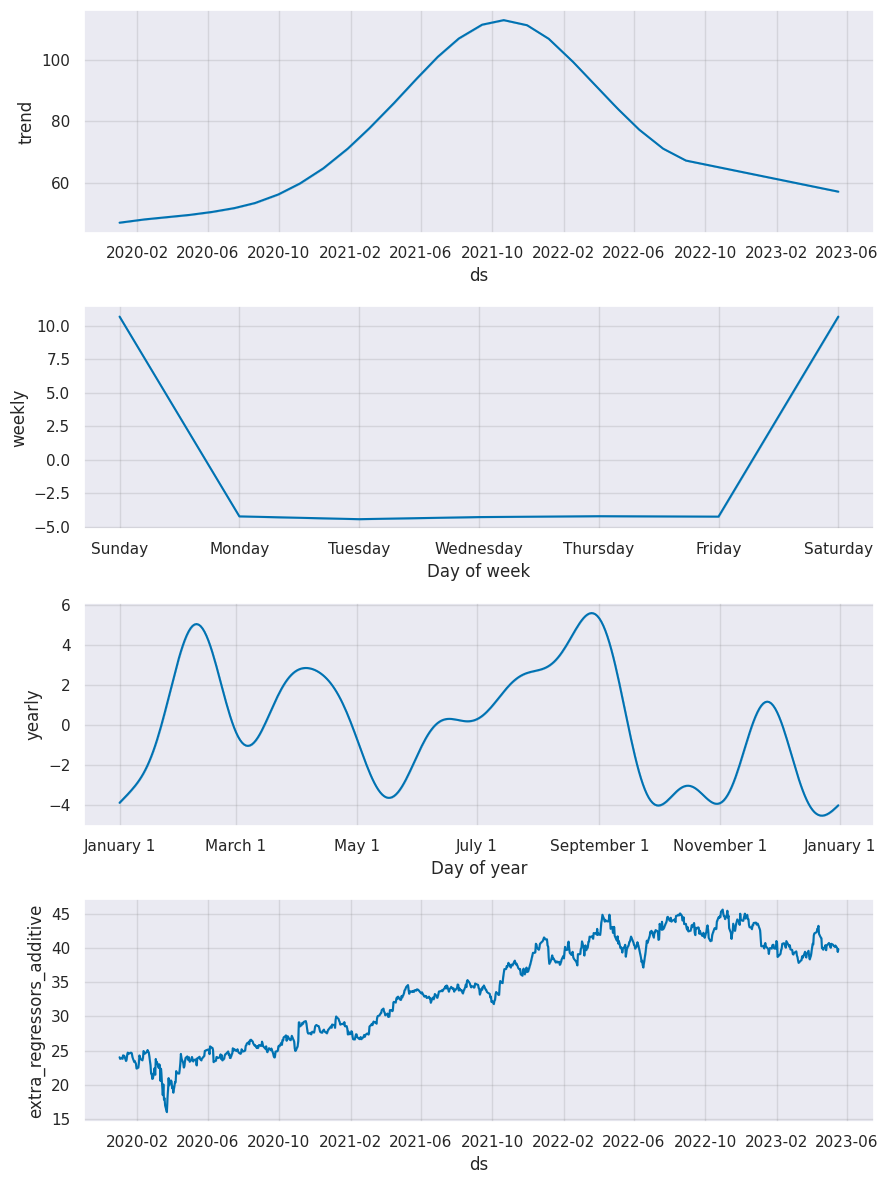

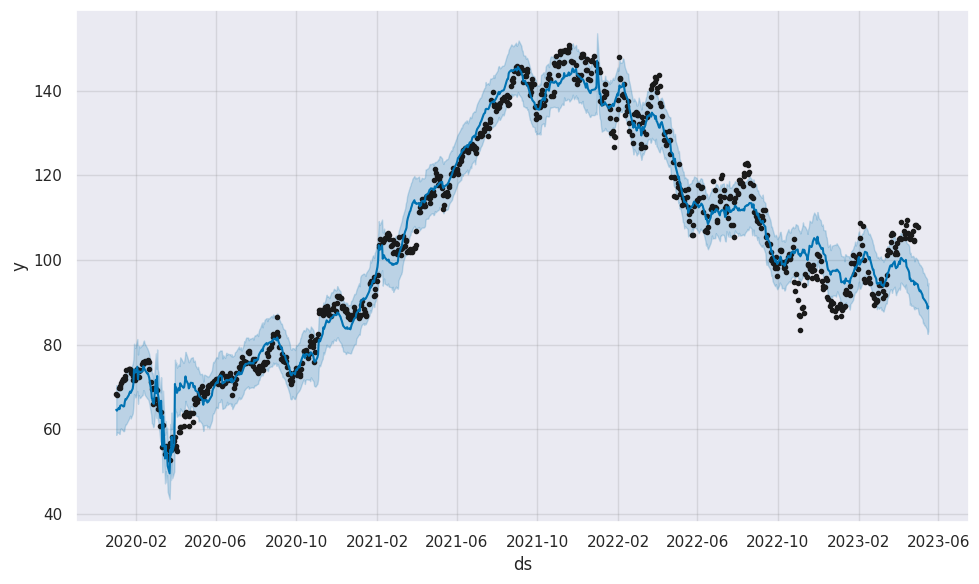

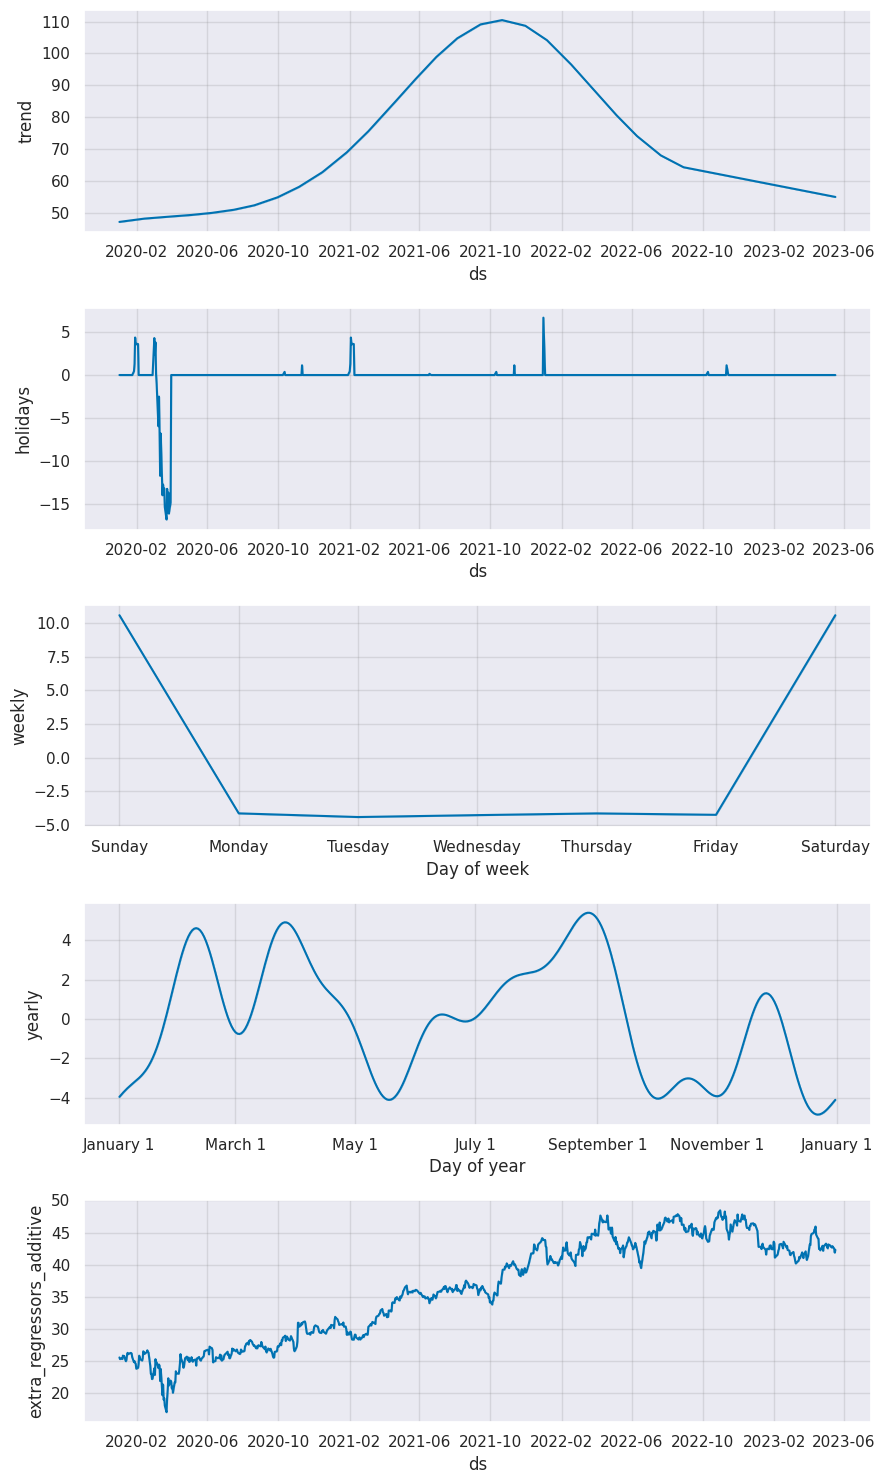

In [99]:
###### Step 1: Install and Import Libraries

# Install libraries
!pip install yfinance prophet

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


###### Step 2: Pull Data

# Data start date
start_date = '2020-01-02'

# Data end date. yfinance excludes the end date, so we need to add one day to the last day of data
end_date = '2023-10-27'

# Date for splitting training and testing dataset
train_end_date = '2023-05-01'

# Pull close data from Yahoo Finance for the list of tickers
ticker_list = ['GOOG', 'UNH']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Take a look at the data
data.head()

# Drop one level of the column names
data.columns = data.columns.droplevel(0)

# Take a look at the data
data.head()

# Information on the dataframe
data.info()

# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['GOOG'])
sns.lineplot(x=data.index, y=data['UNH'])
plt.legend(['Google', 'UNH'])


###### Step 3: Data Processing

# Change variable names
data = data.reset_index()
data.columns = ['ds', 'y', 'UNH']

# Take a look at the data
data.head()

# Check correlation
data.corrwith(data["y"])


###### Step 4: Train Test Split

# Train test split
train = data[data['ds'] <= train_end_date]
test = data[data['ds'] > train_end_date]

# Check the shape of the dataset
print(train.shape)
print(test.shape)

# Check the start and end time of the training and testing dataset
print('The start time of the training dataset is ', train['ds'].min())
print('The end time of the training dataset is ', train['ds'].max())
print('The start time of the testing dataset is ', test['ds'].min())
print('The end time of the testing dataset is ', test['ds'].max())


###### Step 5: Baseline Model

# Use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=16)

# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)

# Visualize the forecast
model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart

# Visualize the forecast components
model_baseline.plot_components(forecast_baseline);

# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')


###### Step 6: Add Seasonality to Baseline Model

# Add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Fit the model on the training dataset
model_season.fit(train)

# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=16)

# Make prediction
forecast_season = model_season.predict(future_season)

# Visualize the forecast
model_season.plot(forecast_season); # Add semi-colon to remove the duplicated chart

# Visualize the forecast components
model_season.plot_components(forecast_season);

# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MAPE value
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')


###### Step 7: Multivariate Model

# Add seasonality
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add regressor
model_multivariate.add_regressor('UNH', standardize=False)

# Fit the model on the training dataset
model_multivariate.fit(train)

# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=16)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, data[['ds', 'UNH']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')


###### Step 8: Model with Holiday Effect and Event Effect

# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

# Add holidays
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=events)

# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')

# Add regressor
model_holiday.add_regressor('UNH', standardize=False)

# Fit the model on the training dataset
model_holiday.fit(train)

# All the holidays and events
model_holiday.train_holiday_names

# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=16)

# Append the regressor values
future_holiday = pd.merge(future_holiday, data[['ds', 'UNH']], on='ds', how='inner')

# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')

# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)

# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

# Visualize the forecast components
model_holiday.plot_components(forecast_holiday);

# Merge actual and predicted values
performance_holiday = pd.merge(test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')

# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

# Summary

In this section, we learned:
* How to include seasonalities in time series prediction using Prophet?
* How to add standard holidays of a country?
* How to add special events such as Super Bowl?
* How to add additional predictors?
* How the time series model performance is impacted by seasonalities, holidays, special events, and additional features?

To learn about how to do time series cross-validation using prophet, please refer to this video [Time Series Forecasting Of Bitcoin Prices Using Prophet](https://grabngoinfo.com/time-series-forecasting-of-bitcoin-prices-using-prophet/).

For more information about data science and machine learning, please check out my [YouTube channel](https://www.youtube.com/channel/UCmbA7XB6Wb7bLwJw9ARPcYg) and [Medium Page](https://medium.com/@AmyGrabNGoInfo).

# References

[1] [Prophet Documentation](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html)